In [1]:
%matplotlib inline

import sys
import datacube
import numpy as np
import pandas as pd
from pandas import DataFrame
import geopandas as gpd
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
from matplotlib import pyplot
from tqdm.auto import tqdm
from datacube.utils import geometry

sys.path.append('../../Scripts')
from dea_spatialtools import xr_rasterize
from dea_datahandling import wofs_fuser
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.utils import masking
from datacube.helpers import ga_pq_fuser, write_geotiff

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [33]:
gauge_data = pd.read_csv('Argyle/Ord_River_PI_357925.1.csv',
                error_bad_lines = False, skiprows=9, escapechar='#',
                         parse_dates=['Timestamp'], 
                         index_col=('Timestamp'),
                        date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0]))
              
reservoir = gpd.read_file('Argyle.shp')
reservoir

,NAME,SHAPE_Leng,SHAPE_Area,Area_calc,lat,lon,geometry
0,LAKE ARGYLE,7.382921,0.084948,1.004587e+09,-16.314509,128.762897,"POLYGON ((128.78655 -16.06790, 128.78790 -16.0..."


In [34]:
gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values('Value')
gauge_data['rownumber'] = np.arange(len(gauge_data))
gauge_data['Exceedence'] = (1-(gauge_data.rownumber/len(gauge_data)))*100
gauge_data = gauge_data.drop(columns=['Interpolation Type', 'Quality Code'])

#Get the depth range and intervals
depth_integers = gauge_data.astype(np.int64)
max_depth = depth_integers.Value.max()
min_depth = depth_integers.Value.min()
integer_array = depth_integers.Value.unique()
integer_list = integer_array.tolist()
len(integer_list)

18

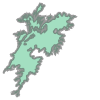

In [25]:
#Define the polygon
df = pd.DataFrame(data = reservoir) #first make pandas dataframe from geopandas dataframe
polygon = df.squeeze() # then have to make pandas series
polygon = polygon.geometry
polygon

In [29]:
#Make a query for the satellite data using the polygon
geom = geometry.Geometry(geom=polygon, crs=reservoir.crs)
query = {'time': ('01-01-1988', '23-02-2021')}
query.update({'geopolygon': geom})

#Dask load wofs data
dc = datacube.Datacube(app='dc-WOfS')
wofs_albers= dc.load(product = 'wofs_albers', dask_chunks = {}, group_by='solar_day', fuse_func = wofs_fuser, **query)

#Make a mask with the polygon
poly_mask = xr_rasterize(reservoir, wofs_albers)
wofs_albers = wofs_albers.where(poly_mask, other=wofs_albers.water.nodata) #put other or all the data turns into 0

gauge_data_xr = gauge_data.to_xarray() #convert gauge data to xarray
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time) #use xarrays .interp() function to merge

  0%|          | 0/18 [00:00<?, ?it/s]

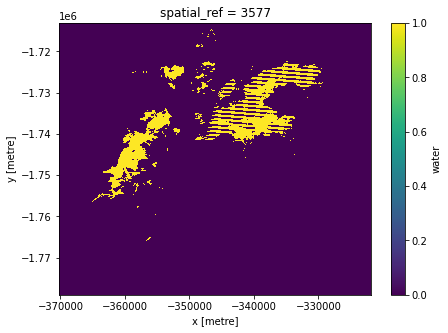

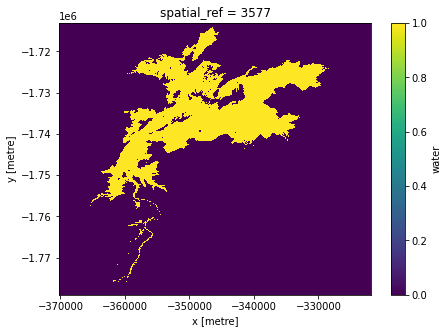

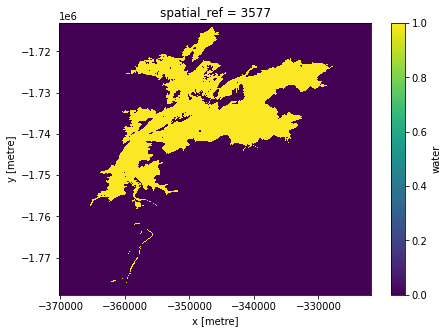

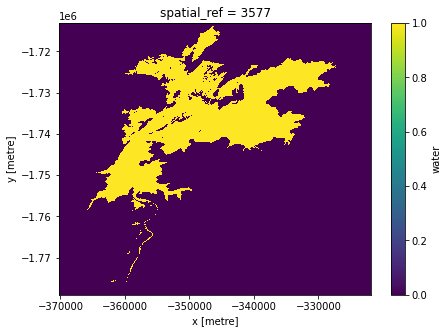

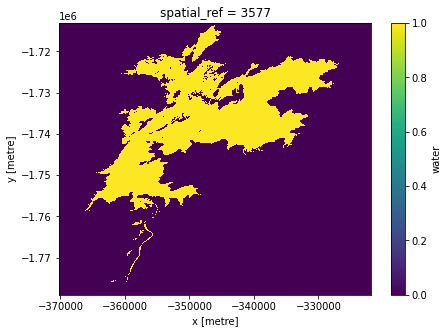

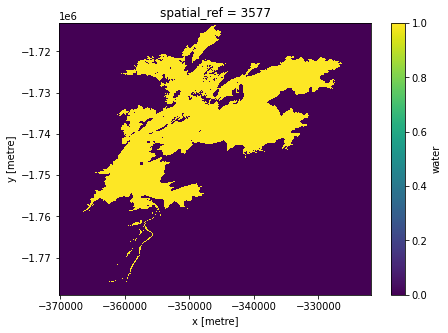

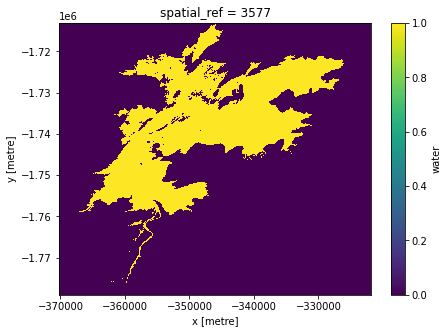

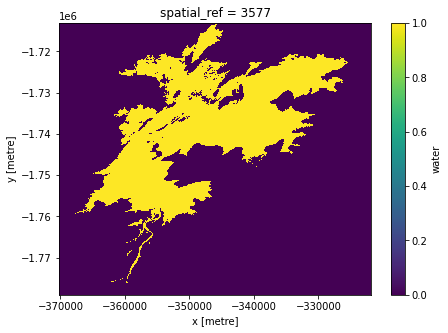

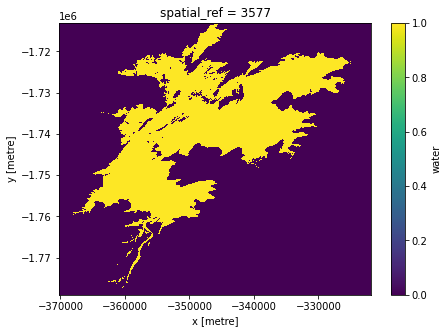

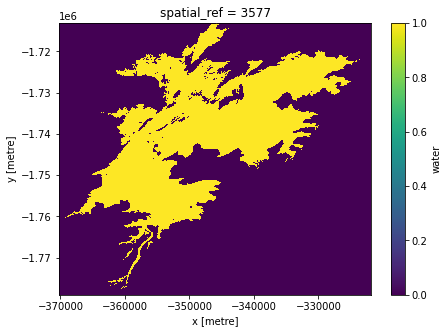

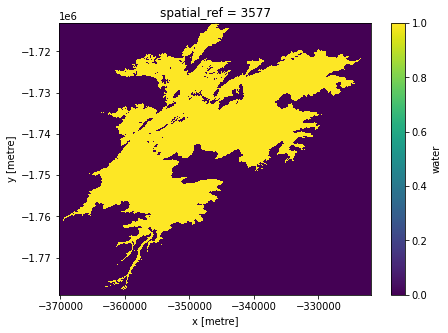

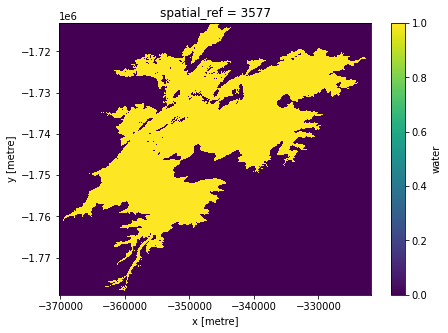

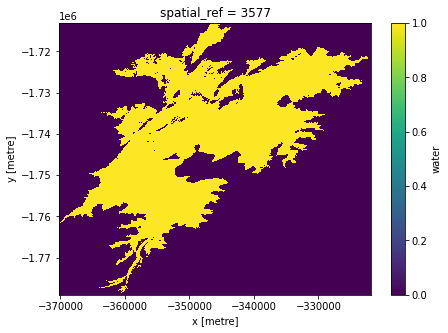

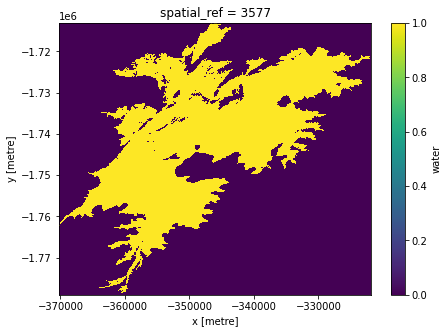

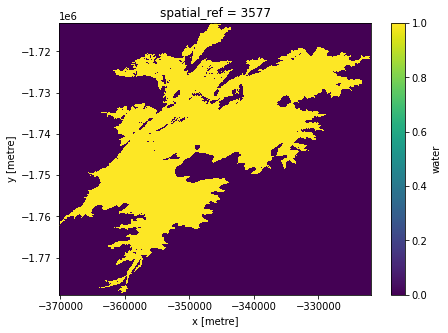

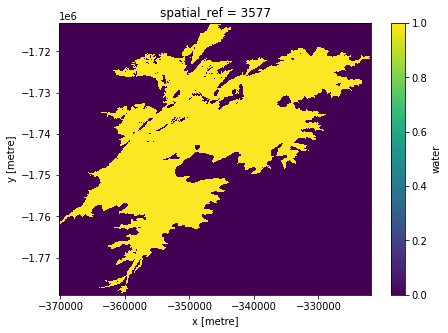

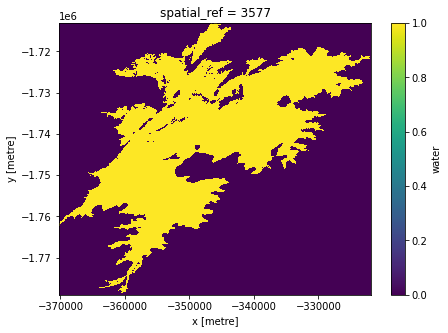

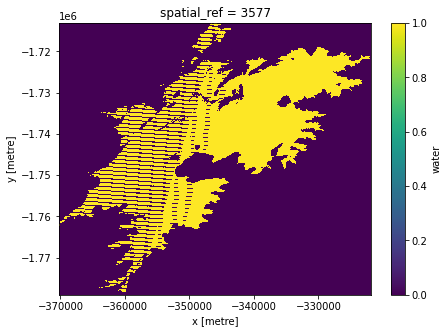

In [51]:
#Load satellite data for every depth interval
surface_area_list = []
number_of_images_list = []
images_post_masking = []
for i in tqdm(integer_list, total=len(integer_list)):
    #If there are more too many depth intervals, take every 2m depth
    if len(integer_list) > 25:
        specified_level = merged_data.where((merged_data.Value > i) & 
                                    (merged_data.Value < i+2), drop=True)
    else:
        specified_level = merged_data.where((merged_data.Value > i) & 
                                    (merged_data.Value < i+1), drop=True)
    
    date_list = specified_level.time.values
    number_of_images = len(date_list)
    number_of_images_list.append(number_of_images)
    specified_passes = wofs_albers.sel(time=date_list).compute() #This .compute() Xarray function loads actual images
    
    #cloudmask (Claire Krause wrote this for me)
    cc = masking.make_mask(specified_passes.water, cloud=True)
    ncloud_pixels = cc.sum(dim=['x', 'y'])
    # Calculate the total number of pixels per timestep
    npixels_per_slice = (specified_passes.water.shape[1] * 
                         specified_passes.water.shape[2])
    cloud_pixels_fraction = (ncloud_pixels / npixels_per_slice)
    clear_specified_passes = specified_passes.water.isel(
        time=cloud_pixels_fraction < 0.2)
    images_post_masking.append(len(clear_specified_passes.time))
    wet = masking.make_mask(clear_specified_passes, wet=True).sum(dim='time')
    dry = masking.make_mask(clear_specified_passes, dry=True).sum(dim='time')
    clear = wet + dry
    frequency = wet / clear
    frequency = frequency.fillna(0)  
    
    #Get area from the satellite data
    #get the frequency array
    frequency_array = frequency.values
    #Turn any pixel in the frequency array with a value greater than 0.2 into a pixel of value 1
    #if the pixel value is 0.2 or lower it gets value 0
    is_water = np.where((frequency_array > 0.2),1,0)
    #give the 'frequency' xarray back its new values of zero and one
    frequency.values = is_water
    #sum up the pixels
    number_water_pixels = frequency.sum(dim=['x', 'y'])
    #get the number
    number_water_pixels = number_water_pixels.values.tolist()
    #multiply by pixel size to get area in m2
    area_m2 = number_water_pixels*(25*25)
    frequency.plot(figsize = (7,5))
    name = 'Argyle', i
    plt.savefig('images/'+str(name)+'.png')    
    surface_area_list.append(area_m2)


In [52]:
#create dataframe of depth to surface area 
depth_to_area_df = DataFrame(integer_list, columns=['Depth'])
depth_to_area_df['Surface Area'] = surface_area_list
depth_to_area_df['NAME'] = 'LAKE ARGYLE'
depth_to_area_df['Number of images before masking'] = number_of_images_list
depth_to_area_df['Number of images after masking'] = images_post_masking
depth_to_area_df

,Depth,Surface Area,NAME,Number of images before masking,Number of images after masking
0,80,189738750,LAKE ARGYLE,2,2
1,81,459788750,LAKE ARGYLE,15,15
2,82,491993125,LAKE ARGYLE,19,17
3,83,542309375,LAKE ARGYLE,33,30
4,84,592714375,LAKE ARGYLE,36,35
5,85,628145625,LAKE ARGYLE,27,27
6,86,683183750,LAKE ARGYLE,24,23
7,87,732655000,LAKE ARGYLE,39,34
8,88,779051875,LAKE ARGYLE,56,43
9,89,838517500,LAKE ARGYLE,71,66


In [53]:
bad_rows = [0]
#Interpolate
obs_list = []
for i, obs in depth_to_area_df.iterrows():
    if i == 0: #We always put the first point in, even if it's bad (will fix later)
        obs_list.append(obs)
        continue
    if obs["Surface Area"] > obs_list[-1]["Surface Area"]: # if the number is bigger than the number before it, keep.
        obs_list.append(obs)

obs_df = pd.DataFrame(obs_list)
obs_df2 = obs_df

#drop the first real images that are bad
obs_df2 = obs_df.drop(index=bad_rows) #Delete rows made from bad images

obs_df3 = obs_df2.set_index("Depth")
min_ = obs_df3.index.min()
max_ = obs_df3.index.max()
obs_df4 = obs_df3.reindex(range(min_, max_+1))
obs_df4['Surface Area'] = obs_df4['Surface Area'].interpolate()
obs_df4['Depth'] = obs_df4.index
obs_df4 = obs_df4[['NAME', 'Depth', 'Surface Area', 'Number of images after masking']]
obs_df4 = obs_df4.set_index("NAME")
obs_df4

,Depth,Surface Area,Number of images after masking
NAME,,,
LAKE ARGYLE,81,459788750,15
LAKE ARGYLE,82,491993125,17
LAKE ARGYLE,83,542309375,30
LAKE ARGYLE,84,592714375,35
LAKE ARGYLE,85,628145625,27
LAKE ARGYLE,86,683183750,23
LAKE ARGYLE,87,732655000,34
LAKE ARGYLE,88,779051875,43
LAKE ARGYLE,89,838517500,66


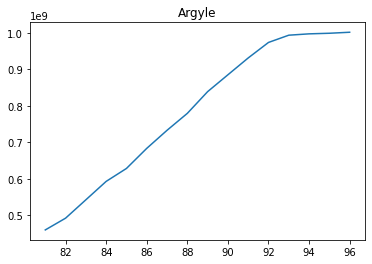

In [55]:
y_orig = list(obs_df4['Surface Area'])
x_orig = list(obs_df4['Depth'])
plt.title('Argyle')
plt.plot(x_orig, y_orig)
plt.savefig('images/'+'Argyle_curve'+'.png')
plt.show()

In [56]:
obs_df4.to_csv('Argyle_Ord_River.csv')